# Aggressive downsampling implementation

Some CNN architecture (e.g. GoogleNet) are based on the strategy of aggressive downsampling: the input image is processed by some initial convolutional layer that strongly reduces the spatial extend of the representation, in order to design a deeper architecture without having too much parameters nor too long execution time.

In this notebook we try to define and train a a custom CNN that exploits Aggressive Downsampling, evaluating then the results on the test set

## Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [5]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

##Data preprocessing

In [7]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [8]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [9]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [10]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [11]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

## Dataset splitting: train and validation

Constants:

In [12]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10
EPOCHS=15

The directories are moved and transformed in order to obtain the train and the test directories:

In [13]:
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [14]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [15]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)

Found 3569 files belonging to 10 classes.
Using 3213 files for training.
Found 3569 files belonging to 10 classes.
Using 356 files for validation.
Found 402 files belonging to 10 classes.


In [16]:
NUM_CLASSES = len(training_images.class_names)

# Aggressive Downsampling model

## Model definition and training

In [17]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
import pathlib

In [18]:
class AggressiveDownsamplingCNN:

    def __init__(self, train=None, test=None, val=None, classes=11, name='AggressiveDownsamplingCNN'):
        # set datasets
        self.training_set = train
        self.val_set = val
        self.test_set = test
        self.name=name 
        
        # model
        inputs = ks.Input(shape=(224, 224, 3))
        x = layers.Rescaling(1. / 255)(inputs)
        x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(7,7), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64)(x)
        outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

        # utils
        self.history = None

        self.dir_name ="/content/drive/Shareddrives/CIDL/project/models/CNN"
        if not os.path.exists(self.dir_name):
          os.makedirs(self.dir_name)
        self.save_path = os.path.join(self.dir_name, name+'.h5')

        self.callbacks_list = [
                  ks.callbacks.ModelCheckpoint(
                      filepath=self.save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True) #saves the best model in terms of the metric in monitor
                  ]

    def compile_and_fit(self, optimizer='adam', loss='categorical_crossentropy', learning_rate=None):
        if learning_rate is not None:
            optimizer.learning_rate = learning_rate

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy']
        )

        self.history = self.model.fit(
             self.training_set,
             epochs=EPOCHS,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )   

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, to_file=str(model_name) +".jpg", show_shapes=True)
    
    def train_more(self, epochs=EPOCHS):
      self.new_history = self.model.fit(
             self.training_set,
             epochs=epochs,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )
      for key in self.history.history.keys():
        self.history.history[key].extend(self.new_history.history[key])

    def load_best_model(self):
      self.model = ks.models.load_model(self.save_path)

    def save_history(self):
      with open(os.path.join(self.dir_name, self.name), 'wb') as file_pi:
        pickle.dump(self.history.history, file_pi)

    def load_history(self):
      with open(os.path.join(self.dir_name, self.name), 'rb') as file_pi:
        history = pickle.load(file_pi)
      return history
    
    def evaluate(self, test=None):
      if test == None:
        test = self.test_set
      test_loss, test_acc = self.model.evaluate(self.test_set)
      print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

    def summary(self):
        self.model.summary()

Define and fit the model

In [ ]:
aggressive_downsampling_model = AggressiveDownsamplingCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
aggressive_downsampling_model.plot_model(model_name="aggressive_downsampling")
aggressive_downsampling_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                         

In [ ]:
aggressive_downsampling_model.compile_and_fit()

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 2.0949 - accuracy: 0.2512
Epoch 00001: val_loss improved from inf to 1.83631, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/AggressiveDownsamplingCNN.h5
26/26 [==============================] - 21s 551ms/step - loss: 2.0947 - accuracy: 0.2509 - val_loss: 1.8363 - val_accuracy: 0.3567
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.7589 - accuracy: 0.3922
Epoch 00002: val_loss improved from 1.83631 to 1.76383, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/AggressiveDownsamplingCNN.h5
26/26 [==============================] - 20s 560ms/step - loss: 1.7576 - accuracy: 0.3931 - val_loss: 1.7638 - val_accuracy: 0.3455
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.6371 - accuracy: 0.4259
Epoch 00003: val_loss improved from 1.76383 to 1.59632, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/AggressiveDownsamplingCNN.h5

In [ ]:
aggressive_downsampling_model.train_more(epochs=5)

Epoch 1/5
25/26 [===========================>..] - ETA: 0s - loss: 0.5357 - accuracy: 0.8153
Epoch 00001: val_loss did not improve from 1.02444
26/26 [==============================] - 21s 567ms/step - loss: 0.5361 - accuracy: 0.8154 - val_loss: 1.1545 - val_accuracy: 0.6404
Epoch 2/5
25/26 [===========================>..] - ETA: 0s - loss: 0.5212 - accuracy: 0.8241
Epoch 00002: val_loss did not improve from 1.02444
26/26 [==============================] - 21s 562ms/step - loss: 0.5220 - accuracy: 0.8238 - val_loss: 1.0564 - val_accuracy: 0.6601
Epoch 3/5
25/26 [===========================>..] - ETA: 0s - loss: 0.4571 - accuracy: 0.8484
Epoch 00003: val_loss did not improve from 1.02444
26/26 [==============================] - 20s 559ms/step - loss: 0.4565 - accuracy: 0.8484 - val_loss: 1.1192 - val_accuracy: 0.6489
Epoch 4/5
25/26 [===========================>..] - ETA: 0s - loss: 0.4704 - accuracy: 0.8391
Epoch 00004: val_loss did not improve from 1.02444
26/26 [=====================

In [ ]:
aggressive_downsampling_model.save_history()

## Visualize results

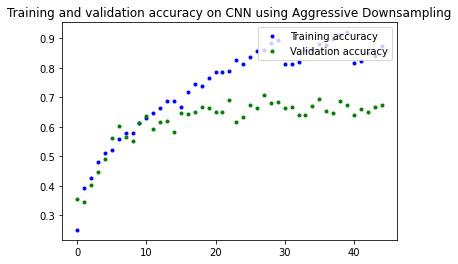

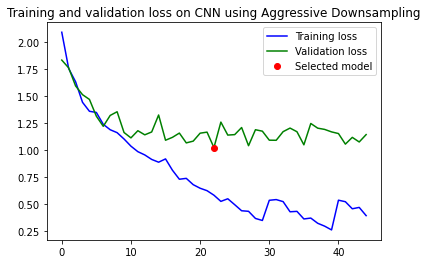

Lowest validation loss has been reached at epoch 22 with validation accuracy of 0.691


In [ ]:
history = AggressiveDownsamplingCNN().load_history()
name = 'CNN using Aggressive Downsampling'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
aggressive_downsampling_model.load_best_model()
aggressive_downsampling_model.evaluate(test_images)

4/4 [==============================] - 3s 42ms/step - loss: 1.0796 - accuracy: 0.6194
Test accuracy: 0.619, test loss: 1.080


## Considerations

This network performs quite good on the validation (and test) set, but until the end of the training process it seems not being able to converge.

Since Adam adapts automatically the learning rate, it must be caused by the dimensione of the network

# Bigger model

## Model definition and training

In [19]:
class BiggerAggressiveDownsamplingCNN(AggressiveDownsamplingCNN):

    def __init__(self, train=None, test=None, val=None, classes=11, name='BiggerAggressiveDownsamplingCNN'):
        super().__init__(train, test, val, classes, name)
        
        # model
        inputs = ks.Input(shape=(224, 224, 3))
        x = layers.Rescaling(1. / 255)(inputs)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(7,7), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
        x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128)(x)
        x = layers.Dense(128)(x)
        outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

Define and fit the model

In [20]:
bigger_aggressive_downsampling_model = BiggerAggressiveDownsamplingCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
bigger_aggressive_downsampling_model.plot_model(model_name="bigger_aggressive_downsampling")
bigger_aggressive_downsampling_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                       

In [ ]:
bigger_aggressive_downsampling_model.compile_and_fit()

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 2.1006 - accuracy: 0.2397
Epoch 00001: val_loss improved from inf to 1.92475, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerAggressiveDownsamplingCNN.h5
26/26 [==============================] - 24s 606ms/step - loss: 2.0990 - accuracy: 0.2406 - val_loss: 1.9247 - val_accuracy: 0.3090
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.8016 - accuracy: 0.3572
Epoch 00002: val_loss improved from 1.92475 to 1.71720, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerAggressiveDownsamplingCNN.h5
26/26 [==============================] - 21s 591ms/step - loss: 1.8011 - accuracy: 0.3570 - val_loss: 1.7172 - val_accuracy: 0.3652
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.5709 - accuracy: 0.4412
Epoch 00003: val_loss improved from 1.71720 to 1.53288, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerAggressive

In [ ]:
bigger_aggressive_downsampling_model.train_more(epochs=10)

Epoch 1/10
25/26 [===========================>..] - ETA: 0s - loss: 0.5454 - accuracy: 0.8141
Epoch 00001: val_loss did not improve from 1.03495
26/26 [==============================] - 21s 566ms/step - loss: 0.5462 - accuracy: 0.8139 - val_loss: 1.2631 - val_accuracy: 0.6039
Epoch 2/10
25/26 [===========================>..] - ETA: 0s - loss: 0.5224 - accuracy: 0.8228
Epoch 00002: val_loss did not improve from 1.03495
26/26 [==============================] - 21s 600ms/step - loss: 0.5225 - accuracy: 0.8223 - val_loss: 1.2476 - val_accuracy: 0.6292
Epoch 3/10
25/26 [===========================>..] - ETA: 0s - loss: 0.3890 - accuracy: 0.8722
Epoch 00003: val_loss did not improve from 1.03495
26/26 [==============================] - 20s 553ms/step - loss: 0.3882 - accuracy: 0.8724 - val_loss: 1.4119 - val_accuracy: 0.6236
Epoch 4/10
25/26 [===========================>..] - ETA: 0s - loss: 0.3584 - accuracy: 0.8791
Epoch 00004: val_loss did not improve from 1.03495
26/26 [=================

In [ ]:
bigger_aggressive_downsampling_model.save_history()

## Visualize results

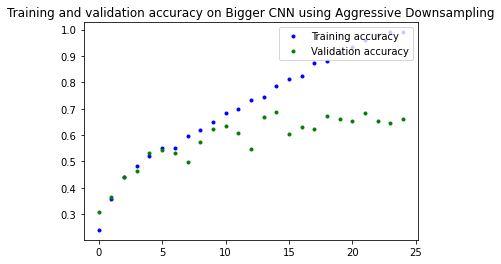

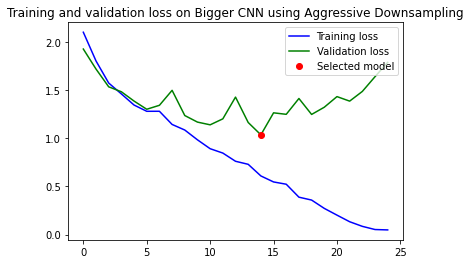

Lowest validation loss has been reached at epoch 14 with validation accuracy of 0.688


In [ ]:
history = BiggerAggressiveDownsamplingCNN().load_history()
name = 'Bigger CNN using Aggressive Downsampling'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [21]:
bigger_aggressive_downsampling_model.load_best_model()
bigger_aggressive_downsampling_model.evaluate(test_images)

4/4 [==============================] - 16s 79ms/step - loss: 0.6340 - accuracy: 0.7910
Test accuracy: 0.791, test loss: 0.634


##Considerations

With a larger network the converegence is actually reached. However, as shown by these results, the increased capacity did not cause an improvement in the prediction power.

# Aggressive Downsampling with Data Augmentation

The aim of data augmentation is to avoid overfitting by generating training images to which we apply small modifications, like random rotations, flipping or scale. In the following, we try to add a Data Augmentation Layer to see if it improves the prediction accuracy of the network

## Model definition

In [ ]:
data_augmentation = ks.Sequential(
  [
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.2) #, 
    #layers.RandomTranslation(height_factor=(-0.1, 0,1), width_factor=(-0.1, 0.1))
  ]
)

In [ ]:
class DataAugmentedAggressiveDownsamplingCNN(BiggerAggressiveDownsamplingCNN):
  def __init__(self, train=None, test=None, val=None, classes=11, name='DataAugmentedAggressiveDownsamplingCNN'):
    super().__init__(train, test, val, classes, name)
    inputs = ks.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    outputs = self.model(x)
    self.model = ks.Model(inputs=inputs, outputs=outputs)


In [ ]:
data_augmented_model = DataAugmentedAggressiveDownsamplingCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
data_augmented_model.plot_model(model_name="DataAugmentedAggressiveDownsamplingCNN")
data_augmented_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model_4 (Functional)        (None, 10)                913034    
                                                                 
Total params: 913,034
Trainable params: 913,034
Non-trainable params: 0
_________________________________________________________________


## Train network on the whole dataset

In [ ]:
data_augmented_model.compile_and_fit()

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 2.0405 - accuracy: 0.2680
Epoch 00001: val_loss improved from inf to 1.98528, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DataAugmentedAggressiveDownsamplingCNN.h5
26/26 [==============================] - 36s 729ms/step - loss: 2.0405 - accuracy: 0.2680 - val_loss: 1.9853 - val_accuracy: 0.3258
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.7844 - accuracy: 0.3537
Epoch 00002: val_loss did not improve from 1.98528
26/26 [==============================] - 22s 583ms/step - loss: 1.7831 - accuracy: 0.3542 - val_loss: 2.2788 - val_accuracy: 0.2949
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.6467 - accuracy: 0.4072
Epoch 00003: val_loss improved from 1.98528 to 1.77769, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DataAugmentedAggressiveDownsamplingCNN.h5
26/26 [==============================] - 22s 623ms/step - loss: 1.6460 - ac

In [ ]:
data_augmented_model.train_more(epochs=20)

Epoch 1/20
25/26 [===========================>..] - ETA: 0s - loss: 1.0808 - accuracy: 0.6206
Epoch 00001: val_loss did not improve from 1.57203
26/26 [==============================] - 25s 591ms/step - loss: 1.0817 - accuracy: 0.6209 - val_loss: 2.2491 - val_accuracy: 0.4242
Epoch 2/20
25/26 [===========================>..] - ETA: 0s - loss: 1.0307 - accuracy: 0.6363
Epoch 00002: val_loss did not improve from 1.57203
26/26 [==============================] - 21s 595ms/step - loss: 1.0301 - accuracy: 0.6365 - val_loss: 1.6671 - val_accuracy: 0.5281
Epoch 3/20
25/26 [===========================>..] - ETA: 0s - loss: 1.0256 - accuracy: 0.6328
Epoch 00003: val_loss did not improve from 1.57203
26/26 [==============================] - 22s 623ms/step - loss: 1.0233 - accuracy: 0.6340 - val_loss: 1.9112 - val_accuracy: 0.4916
Epoch 4/20
25/26 [===========================>..] - ETA: 0s - loss: 0.9433 - accuracy: 0.6681
Epoch 00004: val_loss did not improve from 1.57203
26/26 [=================

In [ ]:
data_augmented_model.save_history()

## Visualize results

In this section, we see the results of the tested classifier analyzing its behavior in terms of accuracy

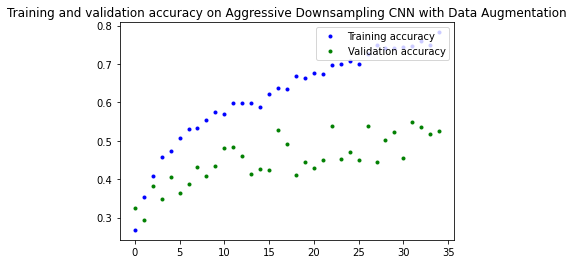

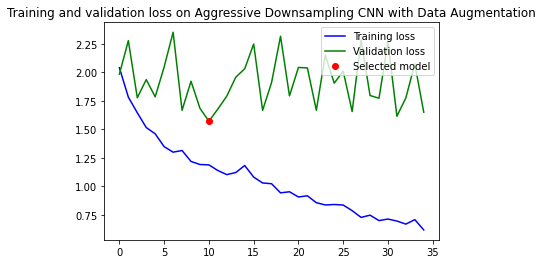

Lowest validation loss has been reached at epoch 10 with validation accuracy of 0.480


In [ ]:
history = DataAugmentedAggressiveDownsamplingCNN().load_history()
name='Aggressive Downsampling CNN with Data Augmentation'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
data_augmented_model.load_best_model()
data_augmented_model.evaluate(test_images)

4/4 [==============================] - 3s 62ms/step - loss: 1.4629 - accuracy: 0.5199
Test accuracy: 0.520, test loss: 1.463


## Considerations

Also in this case the model cannot converge and validation loss is very noisy: data augmentation does not help in this case.